In [ ]:
# importamos librerías
import numpy as np
import random
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [ ]:
# cargamos datos de mnist
mnist = fetch_openml("mnist_784")
X, y = mnist.data, mnist.target.astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# normalizamos los datos y dividimos en conjuntos de entrenamiento y prueba
X = X / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

In [ ]:
tamanio_inp = X_train.shape[1]

In [ ]:
y_train = y_train.reshape(-1, 1) # Se redimensiona para que sea un vector columna
y_test = y_test.reshape(-1, 1)


# Crear el codificador one-hot
encoder = OneHotEncoder(sparse=False) # sparse=False para obtener una matriz densa

# Ajustar y transformar los datos
y_train_hot = encoder.fit_transform(y_train)
y_test_hot = encoder.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
data_train = np.hstack((X_train, y_train_hot))
data_test = np.hstack((X_test, y_test_hot))

In [ ]:
# definimos dimensiones
input_size = tamanio_inp
hidden_size_1 = 100
hidden_size_2 = 50
output_size = 10

In [ ]:
model_weights = dict()

# inicializamos parametros
np.random.seed(0)

model_weights["W_1"] = np.random.randn(input_size, hidden_size_1)*np.sqrt(2./(input_size+hidden_size_1))
model_weights["b_1"] = np.zeros((1, hidden_size_1))
model_weights["W_2"] = np.random.randn(hidden_size_1, hidden_size_2)*np.sqrt(2./(hidden_size_1+hidden_size_2))
model_weights["b_2"] = np.zeros((1, hidden_size_2))
model_weights["W_3"] = np.random.randn(hidden_size_2, output_size)*np.sqrt(2./(hidden_size_2+output_size))
model_weights["b_3"] = np.zeros((1, output_size))

# hiperparámetros
learning_rate = 1e-3
epochs = 10
batch_size = 256

In [ ]:
# funcion de costo
def compute_loss(y, y_pred):
    return -(y*np.log(y_pred)).sum()

In [ ]:
def softMax(x):
    x0 = np.exp(x)
    return x0/(x0.sum(axis=1, keepdims=True))


def ReLu(x):
    return np.maximum(0., x)
def ReLu_derivative(x):
    return np.where(x > 0., 1., 0.)


def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [ ]:
def forward(pesos, input, memoria):
    memoria["z_1"] = input @ pesos["W_1"] + pesos["b_1"]
    memoria["y_1"] = ReLu(memoria["z_1"])
    memoria["z_2"] = memoria["y_1"] @ pesos["W_2"] + pesos["b_2"]
    memoria["y_2"] = ReLu(memoria["z_2"])
    memoria["z_3"] = memoria["y_2"] @ pesos["W_3"] + pesos["b_3"]
    return softMax(memoria["z_3"])

def backpropagation(pesos, lr, y_pred, input, target, memoria):

    grad_loss_y_pred = y_pred - target

    # Gradientes para W3 y b3
    grad_b3 = np.sum(grad_loss_y_pred, axis=0)
    grad_W3 = memoria["y_2"].T @ grad_loss_y_pred

    # Gradientes para W2 y b2
    aux2 = grad_loss_y_pred @ pesos["W_3"].T
    delta_2 = aux2 * ReLu_derivative(memoria["z_2"])

    grad_b2 = np.sum(delta_2, axis=0)
    grad_W2 = memoria["y_1"].T @ delta_2

    # Gradientes para W1 y b1
    aux1 = delta_2 @ pesos["W_2"].T
    delta_1 = aux1 * ReLu_derivative(memoria["z_1"])

    grad_b1 = np.sum(delta_1, axis=0)
    grad_W1 = input.T @ delta_1

    # Actualización de parámetros con descenso de gradiente
    pesos["W_3"] -= lr * grad_W3
    pesos["b_3"] -= lr * grad_b3
    pesos["W_2"] -= lr * grad_W2
    pesos["b_2"] -= lr * grad_b2
    pesos["W_1"] -= lr * grad_W1
    pesos["b_1"] -= lr * grad_b1

In [ ]:
memoria = dict()

# entrenamiento
for epoch in range(epochs):
    np.random.shuffle(data_train)
    total_loss = 0
    for i in range(batch_size, data_train.shape[0]+1, batch_size):
        # lote de datos
        batch_X = data_train[i-batch_size:i, :tamanio_inp]
        batch_Y = data_train[i-batch_size:i, tamanio_inp:]

        # Forward
        y_pred = forward(model_weights, batch_X, memoria)

        # calcular pérdida
        loss = compute_loss(batch_Y, y_pred)
        total_loss += loss

        # Backpropagation
        backpropagation(model_weights, learning_rate, y_pred, batch_X, batch_Y, memoria)

    # calcular la pérdida promedio por época
    avg_loss = total_loss / (data_train.shape[0] // batch_size)

    # avance
    print(f"Epoch {epoch + 1}, Loss: {avg_loss}")

Epoch 1, Loss: 125.32624006725982
Epoch 2, Loss: 51.62705847582255
Epoch 3, Loss: 38.29614457499372
Epoch 4, Loss: 30.23010964916245
Epoch 5, Loss: 24.940386802219955
Epoch 6, Loss: 21.750747254350152
Epoch 7, Loss: 18.896297748529616
Epoch 8, Loss: 16.529008656855083
Epoch 9, Loss: 14.586955404461062
Epoch 10, Loss: 12.851954089488801


In [ ]:
def prediccion(pesos, input):
  z_1 = input @ pesos["W_1"] + pesos["b_1"]
  y_1 = ReLu(z_1)
  z_2 = y_1 @ pesos["W_2"] + pesos["b_2"]
  y_2 = ReLu(z_2)
  z_3 = y_2 @ pesos["W_3"] + pesos["b_3"]
  y_pred = softMax(z_3)
  return np.argmax(y_pred, axis=1)

def mostrar(idx, data, pesos):
  data_X = data_test[idx,:tamanio_inp]
  data_Y = data_test[idx,tamanio_inp:]
  img_reshaped = data_X.reshape(28, 28)

  pred = prediccion(pesos, data_X)

  # Mostrar la imagen
  plt.imshow(img_reshaped, cmap='gray')  # Usar cmap='gray' para escala de grises
  plt.title(f"Prediccion: {pred.item()}")
  plt.show()

In [ ]:
batch_X_t = data_test[:,:tamanio_inp]
batch_Y_t = data_test[:,tamanio_inp:]

predicciones = prediccion(model_weights, batch_X_t)
reales = np.argmax(batch_Y_t, axis=1)

In [ ]:
print( f"Porcentaje de datos clasificados correctamente en el conjunto de test {np.sum(reales == predicciones)/batch_Y_t.shape[0]}")

Porcentaje de datos clasificados correctamente en el conjunto de test 0.973


# Predicciones

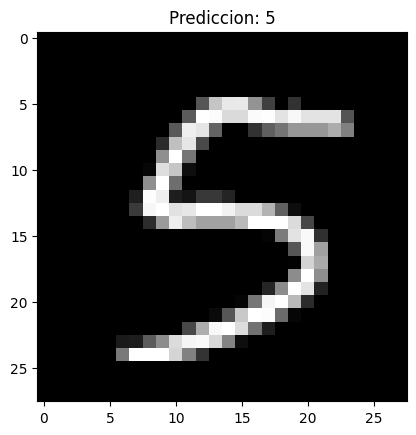

In [ ]:
mostrar(135, data_test, model_weights)

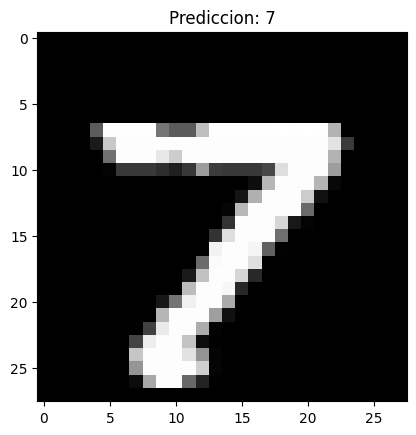

In [ ]:
mostrar(235, data_test, model_weights)

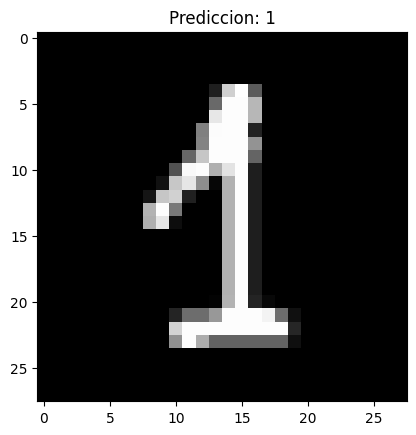

In [ ]:
mostrar(86, data_test, model_weights)